Thank Yous: 

I would like to thank Ernesto, Theo, and Richard for helping me answer quick questions and pointing me out to resources while completing this assignmnent 

# Problem 1

In this first first problem, you will work with GeoTIFF and GeoJSON files, and use GDAL to manipulate geospatial data. You will also use the Python scientific stack to implement simple image processing algorithms, composite (e.g. temporal) operations and remote sensing indices from band data.

For this problem, you will be analyzing and processing imagery from Sentinel 2 (L1C, Top of Atmosphere) taken over the greater Santa Fe metro area from 2019 to 2020. Each GeoTIFF file contains seven bands [red, green, blue, nir, swir1, swir2, alpha]. Upon examination of this dataset, you will notice that the resolution and coordinate reference system of each file does not match.

There is a zip file that contains the contents of this dataset, called s2_santafe.zip

## Setup

In [ ]:
# I like having all of my imports at the top:

import os                   #file handling
import zipfile              #unzipping

import numpy as np          #numbers and ops
import numpy.ma as ma       #masking
from osgeo import gdal      #geo operations
import json                 #reading json 

from tqdm import tqdm       #nice progress bars
from  pprint import pprint  #nice printing

import seaborn as sns             #viz
import matplotlib.pyplot as plt   #viz

#import ee
#ee.Initialize()

## Part 1


For the first part of this problem, you are asked to create a spatially aligned dataset from the provided dataset. Specifically, every file in your output dataset should be at the same resolution, coordinate reference system and spatial extent. I would recommend projecting all your images to UTM. Your code should take the provided input dataset and write out the output dataset. If using GDAL on the command line rather than with the Python bindings, your code can be a bash script or the accompanying equivalent in Python.

There is a GeoJSON file that contains the spatial extent that each image in your output dataset should match, called santafe_crop.geojson.


### Some parameters

In [ ]:
# Some parameters to make the code easier to read and change
# Inputs
WORK_DIR = "/content/drive/MyDrive/RS_HW1/"
ZIP_PATH = '/content/drive/MyDrive/RS_HW1/Homework 1/s2_santafe.zip'
GEOFILE = 'santafe_crop.geojson'
BAND_NUM = 7
MAX_PIXEL_VALUE = 65535

#Outputs
OUT_DIR = "/content/drive/MyDrive/RS_HW1/Output"

# Get the unzipped name and output image folder 
# i.e. (where the images would end up after unzipping)
NAME = ZIP_PATH.split('.')[0].split('/')[-1]
IMAGE_FOLDER = WORK_DIR+NAME

### Output Decisions

We want to reproject to UTM, so I selected the  UTM zone above New Mexico. 

We also want to have the rasters have the same resolution. I looked at the current resolutions and they ranged from about 10-20. Since I don't have a lot of memory/RAM on colab, I decided on an output resolution of 25 (which will lower the warped output size considerably). This downsampling is justified also because we don't need extremely high accuracy to determine the metrics that speak of the entire scene, which is our goal. We may lose out on a couple 'green' or 'snowy' pixels this way, but only if they are isolated (no other like pixels around them) and thus are likely to not influence our metrics significantly. 

If I was working somewhere else I would probably opt for a lower value though, something like 15, to lose less data and make sure my results are high quality. 

In [ ]:
DESIRED_EPSG = 'EPSG:26913'    #  <-- NAD83 / UTM zone 13N - good for NM
OUT_RESOLUTION = 25.0       # (inp ranges ~10-~20) we don't need high res though

### Extracting the zip file

In [ ]:
# Extracting Images if needed
# If we didn't extract the zip, extract it
if not (os.path.exists(IMAGE_FOLDER) or os.path.exists(OUT_DIR)):
  with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
      zip_ref.extractall(WORK_DIR)
      print('Zip extracted')
else:
  print('Zip already extracted')

Zip already extracted


### Removing bad images

I would like to thank Theo for helping me figure this one out. 

Here we remove tif files that have a large portion not within our AOI using the alpha band. We are interested in tif files that have these 'highest' metrics, and thus don't need to consider these files.

In [ ]:
# list of paths to all of the extracted .tif files
img_paths = [IMAGE_FOLDER+'/'+img_name for img_name in os.listdir(IMAGE_FOLDER) if 
              img_name.split('.')[-1] == 'tif']

## One file had a tif.aux,xml extension, I decided to ignore it because 
## the date matched another existing tif file 

In [ ]:
## Check alpha band to see if the image is useful 
for image in tqdm(img_paths, position = 0):
  #get the raster
  raster = gdal.Open(image)  
  
  #If the image was deleted, skip this iteration
  if raster is None: 
    continue

  # Get the alpha band
  band = raster.GetRasterBand(7)  
  alpha = band.ReadAsArray()
  
  # We want to have some metric of how many useable pixles are in the raster
  # so I chose the mean (# of usable pixels/ Total # of pixels)
  mask = np.where(alpha>0,1,0)  
  metric = np.mean(mask)     

  # If < 70% of the pixels are usable, the image is unlikely to be the highest 
  # in the metrics we care about (greenest, snowiest, etc.), therefor I remove
  # them
  if(metric<0.7):
    os.remove(image)

# Update the image path list:
img_paths = [IMAGE_FOLDER+'/'+img_name for img_name in os.listdir(IMAGE_FOLDER) if 
              img_name.split('.')[-1] == 'tif']

0it [00:00, ?it/s]


### gdal warping

I want to thank ernesto for sharing some cites that helped me through this:

[mostly this link](https://www.youtube.com/watch?v=1jHhQKJOQ5M&t=325s&ab_channel=MakingSenseRemotely) 

We want to reproject, resample, and crop our rasters to lie within out AOI. We use gdal.warp to do just that.

In [ ]:
#If we didn't fix the data yet:
if not os.path.exists(OUT_DIR):
  os.mkdir(OUT_DIR)
  # Go through all the tif files and reproject them to desired EPSG
  for img_path in tqdm(img_paths, position = 0):
    # Remove the extension, add a _mod.tiff, remove the previous path, and add the output path:
    img_name = (img_path.split('.')[0]+'_mod.tif').split('/')[-1]
    out_img_path = OUT_DIR+'/'+img_name
    # Perform the warp
    gdal.Warp(out_img_path,
              img_path,
              dstSRS = DESIRED_EPSG,
              xRes = OUT_RESOLUTION,
              yRes = OUT_RESOLUTION,
              resampleAlg =  'bilinear',
              cutlineDSName = WORK_DIR+GEOFILE, 
              cropToCutline = True, 
              dstNodata = np.nan,
              multithread  = True
              )
  #Print 
  print('')
  print('All files modified')

else: 
  print('Data already modified')

Data already modified


We want to make sure that the warping was performed correctly, so we read in each of the output tif files and check them. 

In [ ]:
## CHECK 
mod_names = [im for im in os.listdir(OUT_DIR) if im.split('.')[-1] == 'tif']
for img in tqdm(mod_names, position = 0):
  path = OUT_DIR+'/'+img
  image = gdal.Open(path)
  assert(image.GetGeoTransform()[-1] == -OUT_RESOLUTION)
  assert(image.GetProjection().split('\"')[-2] == DESIRED_EPSG.split(':')[1])
print('')
print('All Good')

100%|██████████| 90/90 [00:00<00:00, 228.43it/s]


All Good


Finally we remove the old images

In [ ]:
# Remove initial files:
for i in os.listdir(IMAGE_FOLDER):
  os.remove(IMAGE_FOLDER+'/'+i)
# We keep the folder empty - this is bc earlier 

## Part 2


Once you have created an aligned dataset, you will perform some analysis on this dataset.

First, you are asked to compute a histogram of values across the entire temporal stack each of the six bands (excluding the alpha band).


### Histogram-ing


We want to create a histogram of our pixel values for each of the bands. The first thing is to get the pixel values of each of the bands for each of the images. 

In [ ]:
#Paths to the warped images
mod_paths = [OUT_DIR+'/'+im for im in os.listdir(OUT_DIR) if im.split('.')[-1] == 'tif']

#Initialize storage for the band values
bands = {
    'red': [],
    'green': [], 
    'blue': [], 
    "near infrared": [], 
    'short wave infrared 1': [], 
    'short wave infrared 2': [], 
    'alpha': [],
}

for img in tqdm(mod_paths, position = 0):
  # Open the tif file
  # Since opening the files is the expensive op, I put it in the outer loop
  ds = gdal.Open(img)
  for band_i in range(1, BAND_NUM+1):
    # get the band
    band = ds.GetRasterBand(band_i)
    # Get the band name
    band_name = json.loads(band.GetDescription())['description'].lower()
    # Quick fix for the alpha band
    if band_name == 'alpha (valid data)':
      band_name = 'alpha'
    # Append to a list for the correct band
    bands[band_name].append(band.ReadAsArray())
  

# Stack all of the rasters so that we can perform temporal analysis
for band, images in tqdm(bands.items(), position=0):
  bands[band] = np.stack(images)

## Note: first dim is time, then y axis, and finally x axis

100%|██████████| 7/7 [00:00<00:00, 51.66it/s]


Here we generate the actual instagram. Since we saved all of the band information in a dictionary, this becomes pretty nice code-wise. 

100%|██████████| 6/6 [05:53<00:00, 58.88s/it]


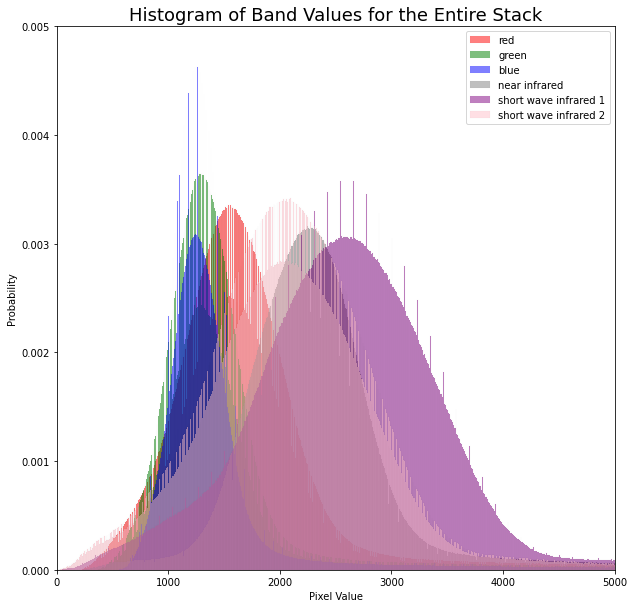

In [ ]:
### Make the histograms
# List of colors I plan to use
color_list = ['red', 'green', 'blue', 'gray', 'purple', 'pink']

plt.figure(figsize=(10,10))
# iterate over the dictionary keys (minus alpha) and use the df & colors above for 
# plotting 
for i, band in enumerate(tqdm(list(bands.keys())[:-1], position = 0)):
  sns.histplot(bands[band].flatten(),
               stat= 'probability',
               color=color_list[i], 
               alpha = 0.5  #For see through plot
               )

# Plot lables and limits
plt.title('Histogram of Band Values for the Entire Stack', 
          fontsize = 18)
plt.xlabel('Pixel Value')
plt.legend(bands.keys())

# I manually crop the bounds to show the 'interesting region in the histogram'
plt.ylim(0, 0.005)
plt.xlim(0, 5e3)

# Save the image as an svg in case I need it later
plt.savefig(WORK_DIR+'Histogram_pixel_values_all_bands.svg',
            format='svg',
            transparent = True)

# show the plot
plt.show()

#### Histogram Comments

We see that the pixel values per band seem to follow a gaussian-like distribution. We also see that for each band the mean and the stdv are slightly different. The last thing we notice, as seen by the cropping done, is that the RGB range doesn't really exceed 3000 (a majority of the RGB pixels are bellow this value) and similarly when we consider all of the bands, the pixel values tend to be bellow 5000. This may be useful for plotting later

### Finding -est metrics


Next, across the temporal stack, you are asked to:
* Find the greenest scene (e.g. most vegetated scene -> max(NDVI))
* Find the snowiest scene (NDSI)
* Find the cloudiest scene
* Find the brightest scene


Note that your outputs should be from the result of your technique / code / algorithm running on the stack of imagery. You are NOT allowed to produce your answers simply through visual inspection of the data, although you will certainly want to inspect the data closely to figure out what approach to take. For each answer, provide the scene ID and the corresponding image to answer each question.


In [ ]:
#Initialize a dictionary to save our output values
highest_vals = {'greenest': {'masked': None,
                             'unmasked': None},
                'snowiest': {'masked': None,
                             'unmasked': None},
                'cloudiest': None,
                'brightest': {'masked': None,
                             'unmasked': None}}

#### Cloud Masking

Before we go and analyze the images, we want to apply a cloud mask to remove the influence of clouds on the results. I ended up doing both (with and without cloudmask) to see the differences in the results.

##### Useful functions (for visualization)

Generally take the bands dict from before and an image index, extracts 3 bands to map to our three visual channels, and outputs an RBG representation of these channels


In [ ]:
def bands_to_rgb(idx = None, bands = bands):
  '''
  takes raster index, reads the raster's rgb bands and outputs a normalized
  3d image

  paramaters:
  ---
  idx - (default is None) key index in the bands dictionary
  bands - (default to the bands previously extracted) a dictionary containing 
  stacks of band pixel values (img_idx, y_axis, x_axis)
  '''

  # If we don't have an index -> only one image, stack that one image otherwise
  # index into the bands to get the right image
  if idx is not None:
    im = np.dstack((bands['red'][idx],bands['green'][idx],bands['blue'][idx]))
  else:
    im = np.dstack((bands['red'],bands['green'],bands['blue']))
  im = im/np.max(im)
  return im

In [ ]:
#Visualize an image but using swir & blue (geology)
def show_geology (idx, bands = bands):
  '''
  Takes an image index in the bands dictionary and prints out the Sw2Sw1B picture it 
  corresponds to. 
  
  paramaters:
  ---
  idx - key index in the bands dictionary
  bands - (default to the bands previously extracted) a dictionary containing 
  stacks of band pixel values (img_idx, y_axis, x_axis)
  '''
  im = np.dstack((bands['short wave infrared 2'][idx],bands['short wave infrared 1'][idx],bands['blue'][idx]))
  im = im/np.max(im)
  plt.figure(figsize = (5,5))
  plt.imshow(im)

In [ ]:
def show_rgb (idx, bands = bands):
  '''
  Takes an image index in the bands dictionary and prints out the RGB picture it 
  corresponds to. 
  
  paramaters:
  ---
  idx - key index in the bands dictionary
  bands - (default to the bands previously extracted) a dictionary containing 
  stacks of band pixel values (img_idx, y_axis, x_axis)
  '''
  im = np.dstack((bands['red'][idx],bands['green'][idx],bands['blue'][idx]))
  im = im/np.max(im)
  plt.figure(figsize = (5,5))
  plt.imshow(im)

In [ ]:
def show_img_masked (idx, bands = bands):
  '''
  Takes an image index in the bands dictionary and prints out the RGB picture it 
  corresponds to with the previously calculated mask overlayed.
  
  paramaters:
  ---
  idx - key index in the bands dictionary
  bands - (default to the bands previously extracted) a dictionary containing 
  stacks of band pixel values (img_idx, y_axis, x_axis)
  '''
  im = np.dstack((bands['red'][idx],bands['green'][idx],bands['blue'][idx]))
  im[:,:,0] = im[:,:,0]*bands['cloudmask'][idx]*bands['alpha'][idx]
  im[:,:,1] = im[:,:,1]*bands['cloudmask'][idx]*bands['alpha'][idx]
  im[:,:,2] = im[:,:,2]*bands['cloudmask'][idx]*bands['alpha'][idx]
  
  im = im/np.max(im)
  plt.figure(figsize = (5,5))
  plt.imshow(im)
  plt.show()

##### Cloud Mask

Use SWIR1, SWIR2, /& Blue bands to compute a 'greyscale'-like metric to summarize all three values. Then a threshold is applied on this greyscale mapping to obtain a binary cloudmask.

In [ ]:
## Cloud mask
# I found this number using trial and error:
CLOUD_THRESHOLD = 2900

# initialize mask to zero
bands['cloudmask'] = np.zeros(bands['blue'].shape)

# loop over the rasters indices:
for i in range(bands['cloudmask'].shape[0]):
  #get the swir1, swir2, and blue bands 
  swir1 =  bands['short wave infrared 1'][i]
  swir2 = bands['short wave infrared 2'][i]
  blue = bands['blue'][i]

  # I wanted one metric as opposed to a 3, so I decided to use the RGB -> grey
  # conversion with the 3 bands I have. Since clouds appear purple-blue, and 
  # ground appears more green I assign the highest coeff to blue and lowest to
  # swir1:
  grey = 0.2989 * swir2 + 0.1140 * swir1 + 0.5870 * blue

  # Create a binary mask where the grey exceeds the threshold 
  bands['cloudmask'][i,:,:] = np.where(grey>CLOUD_THRESHOLD, False, True)

#### Cloudiest
Now that we have a cloudmask, we see which tif file had the most cloud pixels and is therefore the cloudiest. 

In [ ]:
## Cloudiest scene:
idx_cloudiest = np.argmin(np.sum(np.sum(bands['cloudmask'], axis = 1), axis = 1))
highest_vals['cloudiest'] = mod_paths[idx_cloudiest]

## Save the cloudiest scene for later
cloudiest = bands_to_rgb(idx_cloudiest)

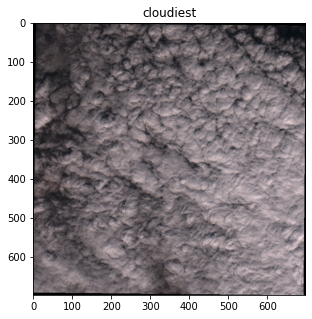

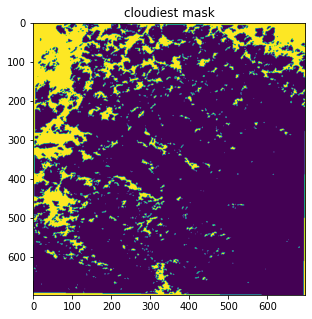

In [ ]:
# Display
plt.figure(figsize=(5,5))
plt.imshow(cloudiest)
plt.title('cloudiest')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(bands['cloudmask'][idx_cloudiest])
plt.title('cloudiest mask')
plt.show()

#### Applying the cloud masks

In [ ]:
### Apply the masks to the rasters
def apply_masks(keys, bands = bands):
  '''
  Applies the clodmask in the bands dict to the values in the keys specified and
  outputs as a new dict. 

  parameters:
  ---
  keys - keys of the bands dict to returned the masked arrays for
  bands - a dict that stores band image stacks
  '''
  # initialize the output dictionary
  masked = {}

  #for the keys we are looking for:
  for key in keys:
    # init key
    masked[key] = np.zeros(bands[key].shape)
    # look at the geotiff extracted bands one image at a time and mask them
    for idx in range(bands[key].shape[0]):
      # masked[key][idx,:,:] = bands[key][idx,:,:]*bands['cloudmask'][idx]*bands['alpha'][idx]
      masked[key][idx,:,:] = ma.masked_array(bands[key][idx,:,:], mask=bands['cloudmask'][idx]*bands['alpha'][idx])

  # return the masked bands
  return masked

In [ ]:
# Mask all of the bands (last two keys are alpha and cloudmask and don't need
# aditional masking)
masked = apply_masks(list(bands.keys())[:-2])

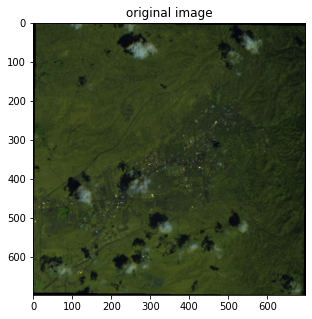

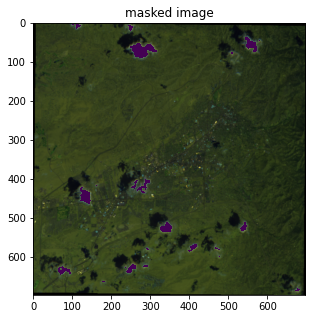

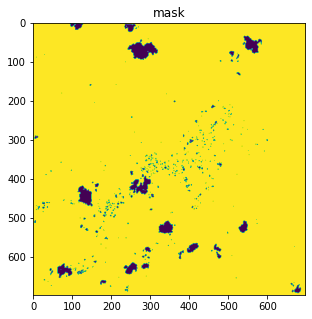

In [ ]:
# Checking that the masks are applied
idx = 89

show_geology(idx)
plt.title('original image')
plt.show()

show_geology(idx, bands = masked)
plt.imshow(np.where(bands['cloudmask'][idx] == True, np.nan, 1))
plt.title('masked image')
plt.show()

# mask
plt.figure(figsize=(5,5))
plt.imshow(bands['cloudmask'][idx])

plt.title('mask')
plt.show()

##### Cloudmask Comments
We see that the cloud mask does a pretty decent job at covering clouds, but sometimes ends up covering other parts of the image as well (such as what I believe is snow or houses). I tried to choose a threshold that doesn't seem to mask non-cloud areas, but to be more sure this is the case I would probably need some sort of labeled image (where it labels if something is a cloud or not) to acually judge my algorithm and more accurately select a threshold value. 

#### Normalized Differences (Greenest \& Snowiest)

We note that there will be nan bc of division by zero, but that is okay (we later ignore them)!

In [ ]:
def dif_over_sum(arr1, arr2):
  '''
  Calculates the difference over the sum
  (arr1-arr2)/(arr1+arr2)

  paramaters 
  ---
  arr1 - np.array 
  arr2 - np.array same size as arr1
  '''
  assert(arr2.shape == arr1.shape)
  return np.divide((arr1-arr2),(arr1+arr2))

We compute NDVI \& NDSI to be able to determine the greenest and snowiest scenes respectively. 

In [ ]:
# unmasked
NDVI = np.zeros(bands['green'].shape)
NDSI = np.zeros(bands['green'].shape)
# masked
NDVI_m = np.zeros(bands['green'].shape)
NDSI_m = np.zeros(bands['green'].shape)
# Ran into ram issues and solved it with a loop, it should really be needed though
for i in range(len(mod_paths)):
  NDVI[i,:,:] = dif_over_sum(bands["near infrared"][i,:,:], bands['red'][i,:,:])
  NDVI_m[i,:,:] = dif_over_sum(masked["near infrared"][i,:,:], masked['red'][i,:,:])
  NDSI[i,:,:] = dif_over_sum(bands["green"][i,:,:], bands['short wave infrared 1'][i,:,:])
  NDSI_m[i,:,:] = dif_over_sum(masked["green"][i,:,:], masked['short wave infrared 1'][i,:,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
## Find greenest and snowiest
idx_greenest = np.argmax(np.sum(np.nansum(NDVI, axis = 1),axis = 1))
idx_greenest_m = np.argmax(np.sum(np.nansum(NDVI_m, axis = 1),axis = 1))
idx_snowiest =np.argmax(np.sum(np.nansum(NDSI, axis = 1),axis = 1))
idx_snowiest_m =np.argmax(np.sum(np.nansum(NDSI_m, axis = 1),axis = 1))

# Store the path to the tifs we found
highest_vals['greenest']['unmasked'] = mod_paths[idx_greenest]
highest_vals['greenest']['masked'] = mod_paths[idx_greenest_m]
highest_vals['snowiest']['unmasked'] = mod_paths[idx_snowiest]
highest_vals['snowiest']['masked'] = mod_paths[idx_snowiest_m]

# store the images of corresponding to the indices found
NDVI_im = NDVI[idx_greenest]
NDVI_im_m = NDVI_m[idx_greenest_m]
NDSI_im = NDSI[idx_snowiest]
NDSI_im_m = NDSI_m[idx_snowiest_m]

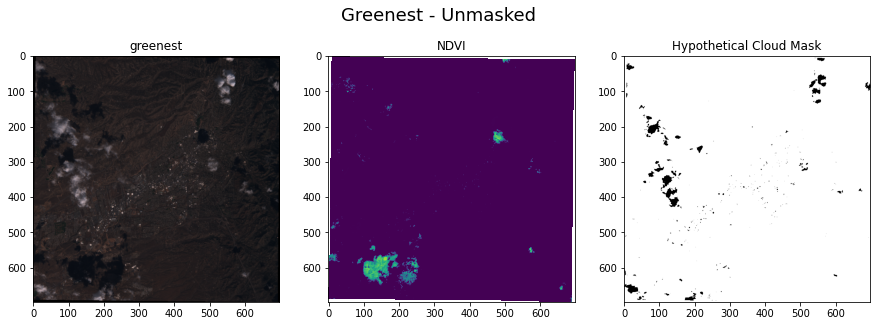

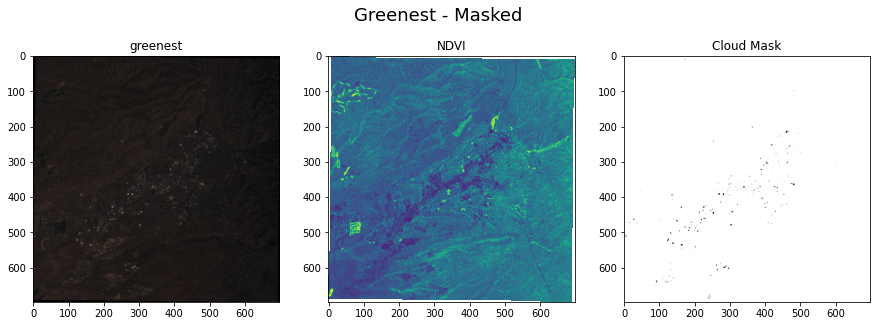

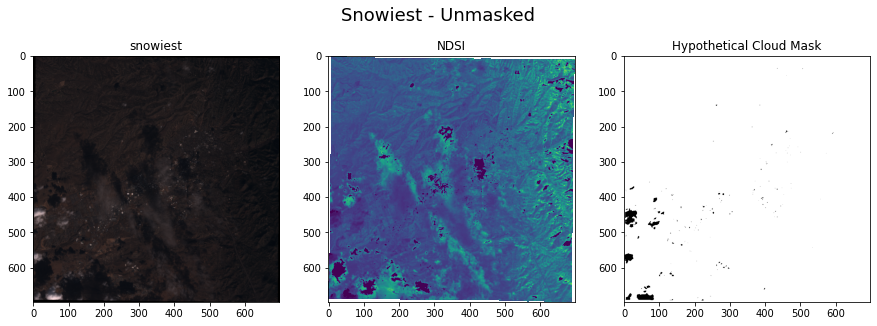

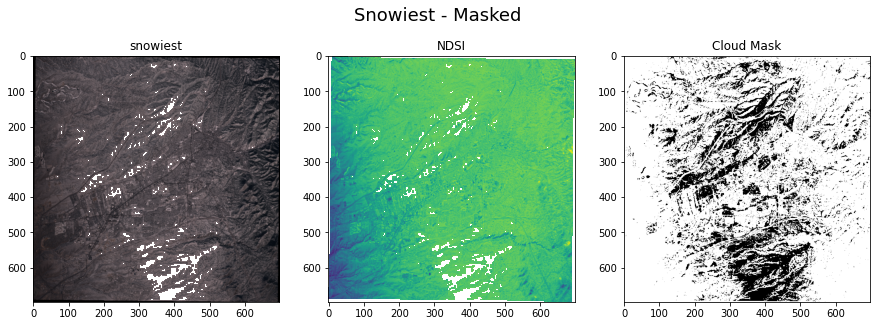

In [ ]:
# Visualization
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_greenest))
ax1.set_title('greenest')
ax2.imshow(NDVI_im)
ax2.set_title('NDVI')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_greenest]), cmap='Greys')
ax3.set_title('Hypothetical Cloud Mask')
plt.suptitle('Greenest - Unmasked', fontsize = 18)
plt.show()


f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_greenest_m))
ax1.imshow(np.where(bands['cloudmask'][idx_greenest_m] == True, np.nan, 1), cmap='binary')
ax1.set_title('greenest')
ax2.imshow(NDVI_im_m)
ax2.imshow(np.where(bands['cloudmask'][idx_greenest_m] == True, np.nan, 1), cmap='binary')
ax2.set_title('NDVI')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_greenest_m]), cmap='Greys')
ax3.set_title('Cloud Mask')
plt.suptitle('Greenest - Masked', fontsize = 18)
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_snowiest))
ax1.set_title('snowiest')
ax2.imshow(NDSI_im)
ax2.set_title('NDSI')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_snowiest]), cmap='Greys')
ax3.set_title('Hypothetical Cloud Mask')
plt.suptitle('Snowiest - Unmasked', fontsize = 18)
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_snowiest_m))
ax1.imshow(np.where(bands['cloudmask'][idx_snowiest_m] == True, np.nan, 1), cmap='binary')
ax1.set_title('snowiest')
ax2.imshow(NDSI_im_m)
ax2.imshow(np.where(bands['cloudmask'][idx_snowiest_m] == True, np.nan, 1), cmap='binary')
ax2.set_title('NDSI')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_snowiest_m]), cmap='Greys')
ax3.set_title('Cloud Mask')
plt.suptitle('Snowiest - Masked', fontsize = 18)
plt.show()

In [ ]:
## Running into RAM problems - so I remove started to remove variables I won't 
## need
NDSI = None
NDSI_m = None

##### Greenest \& Snowiest Comments

The results shown here show the importance of cloudmasking. The highest images for both greenest and snowiest were 'wrong' when we didn't found them without using the cloudmask (The clouds influenced our results!). 

Also, considering the visualization, it may seem odd that the algorithm picked a different image for the unmasked snowiest image compared to the masked one (the masked NDSI shows that the image found with masking has A LOT of high NDSI value pixels). This is due to the how imshow represents the image! The colors are decided per image, so what appears as very bright green in the NDSI image with the mask may not be a bright green on the NDSI image without the mask.

#### Brightest

By brightest we intend perceptual brightness as seen through the RGB channels/bands. I opted to take a sum as opposed to normalizing by the number of bands used because it allows for simpler computation with no drawback (max of a set is the same index as the max of that set divided by a constant). 

In [ ]:
# Intialize
brightness = np.zeros(bands['blue'].shape[0])
brightness_m = np.zeros(bands['blue'].shape[0])

# Each of the channels 
for i in range(brightness.shape[0]):
  # Find the pixel 
  brightness[i] = np.sum(bands['red'][i]+bands['green'][i]+bands['blue'][i])

  #Since we are addition we need to re-introcude the mask through multiplication
  brightness_m[i] = np.sum((masked['red'][i]+masked['green'][i]+masked['blue'][i])*bands['cloudmask'][i])

In [ ]:
# get index
idx_brightest = np.argmax(brightness)
idx_brightest_m = np.argmax(brightness_m)

# store path to geotiff
highest_vals['brightest']['unmasked'] = mod_paths[idx_brightest]
highest_vals['brightest']['masked'] = mod_paths[idx_brightest_m]

# store the brightness at the brightest index
brightness_im = bands['red'][idx_brightest]+bands['green'][idx_brightest]+bands['blue'][idx_brightest]
brightness_im_m = bands['red'][idx_brightest_m]+bands['green'][idx_brightest_m]+bands['blue'][idx_brightest_m]

In [ ]:
## More cleaning
brightness = None
brightness_m = None

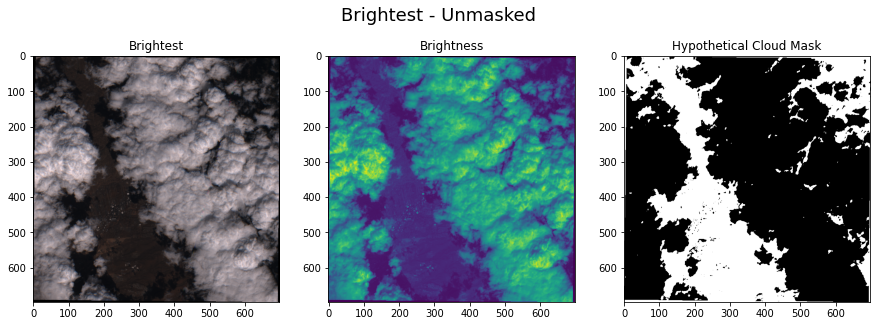

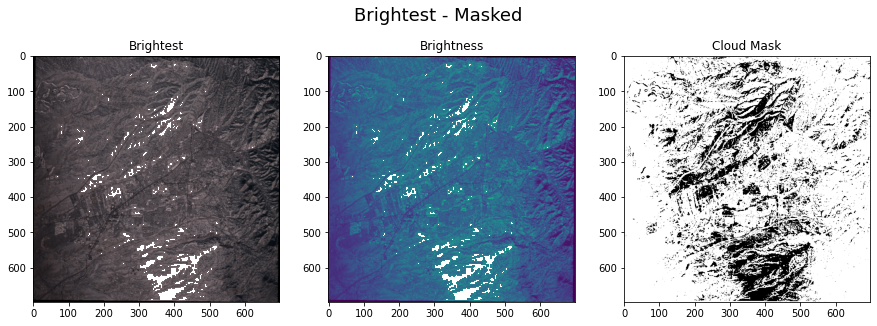

In [ ]:
# Visualize
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_brightest))
ax1.set_title('Brightest')
ax2.imshow(brightness_im)
ax2.set_title('Brightness')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_brightest]), cmap='Greys')
ax3.set_title('Hypothetical Cloud Mask')
plt.suptitle('Brightest - Unmasked', fontsize = 18)
plt.show()


f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
ax1.imshow(bands_to_rgb(idx_brightest_m))
ax1.imshow(np.where(bands['cloudmask'][idx_brightest_m] == True, np.nan, 1), cmap='binary')
ax1.set_title('Brightest')
ax2.imshow(brightness_im_m)
ax2.imshow(np.where(bands['cloudmask'][idx_brightest_m] == True, np.nan, 1), cmap='binary')
ax2.set_title('Brightness')
ax3.imshow(np.logical_not(bands['cloudmask'][idx_brightest_m]), cmap='Greys')
ax3.set_title('Cloud Mask')
plt.suptitle('Brightest - Masked', fontsize = 18)
plt.show()

#### Highest Metric Summary

A quick summary of the results for this section. 
First we disply the image paths to the tif files that we consider to match our metrics best (note that since I had both masked and unmasked results for some metrics, both paths are included). 

Then I also decided to visuallize the resulting tiff files (plotted as RGB and the metric used to evaluate if the image is 'highest, i.e. NDVI, NDSI, etc.) and compare the results between with and without cloud masking. 

In [ ]:
pprint(highest_vals)

{'brightest': {'masked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-12-13_mod.tif',
               'unmasked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-03-15_mod.tif'},
 'cloudiest': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-11-10_mod.tif',
 'greenest': {'masked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-09-09_mod.tif',
              'unmasked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-11-03_mod.tif'},
 'snowiest': {'masked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-12-13_mod.tif',
              'unmasked': '/content/drive/MyDrive/RS_HW1/Output/sentinel-2:L1C_2018-01-07_mod.tif'}}


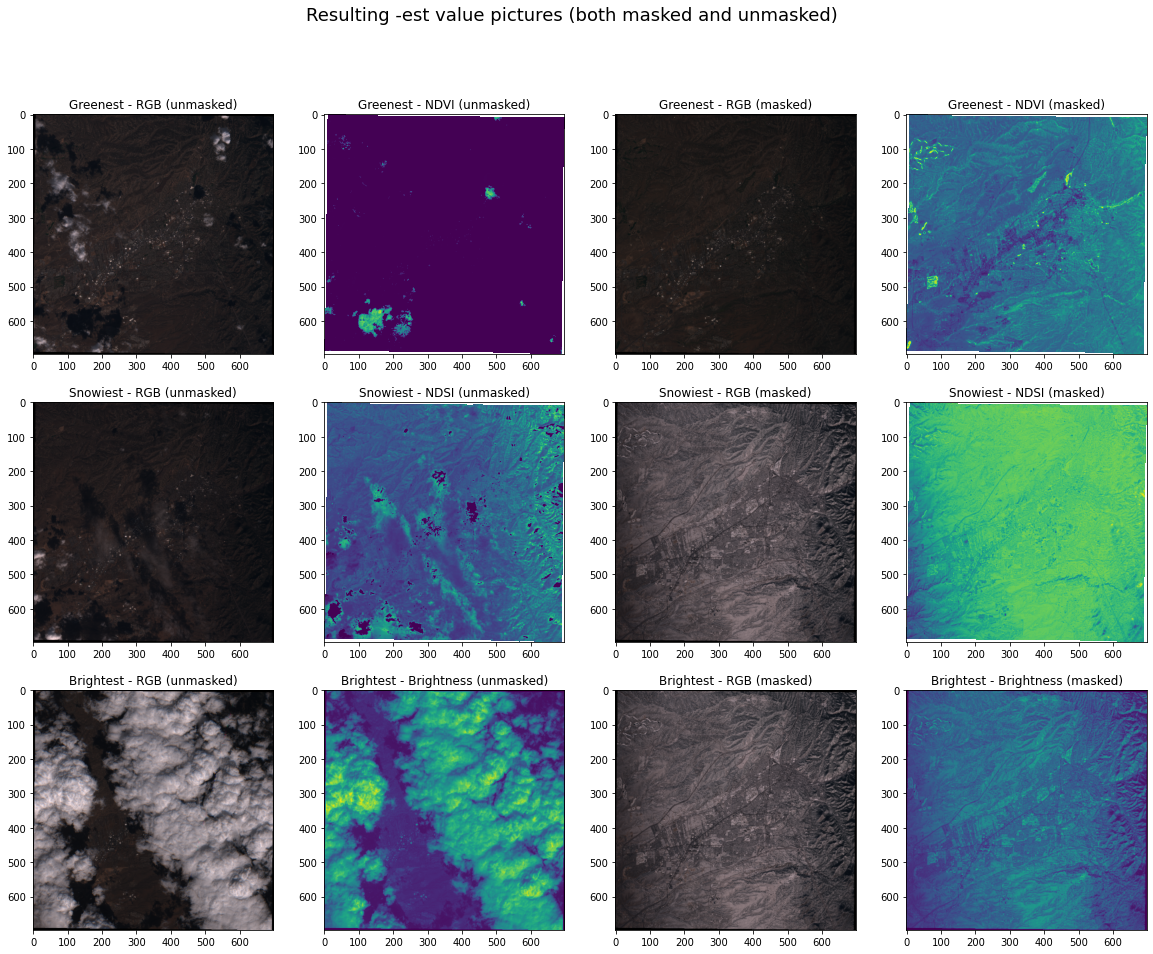

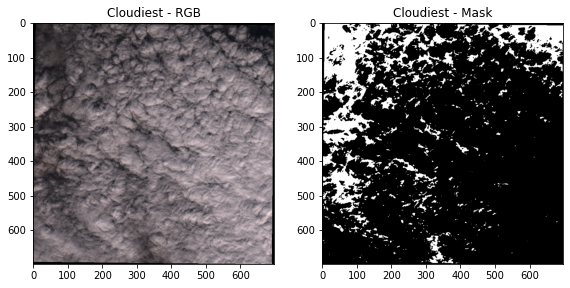

In [ ]:
greenest = bands_to_rgb(idx_greenest)
greenest_m = bands_to_rgb(idx_greenest_m)
snowiest = bands_to_rgb(idx_snowiest)
snowiest_m = bands_to_rgb(idx_snowiest_m)
brightest = bands_to_rgb(idx_brightest)
brightest_m = bands_to_rgb(idx_brightest_m)


## Plotting the results

f, axarr = plt.subplots(3,4, figsize = (20,15))
axarr[0,0].imshow(greenest)
axarr[0,0].set_title('Greenest - RGB (unmasked)')
axarr[0,1].imshow(NDVI_im)
axarr[0,1].set_title('Greenest - NDVI (unmasked)')
axarr[0,2].imshow(greenest_m)
axarr[0,2].set_title('Greenest - RGB (masked)')
axarr[0,3].imshow(NDVI_im_m)
axarr[0,3].set_title('Greenest - NDVI (masked)')


axarr[1,0].imshow(snowiest)
axarr[1,0].set_title('Snowiest - RGB (unmasked)')
axarr[1,1].imshow(NDSI_im)
axarr[1,1].set_title('Snowiest - NDSI (unmasked)')
axarr[1,2].imshow(snowiest_m)
axarr[1,2].set_title('Snowiest - RGB (masked)')
axarr[1,3].imshow(NDSI_im_m)
axarr[1,3].set_title('Snowiest - NDSI (masked)')


axarr[2,0].imshow(brightest)
axarr[2,0].set_title('Brightest - RGB (unmasked)')
axarr[2,1].imshow(brightness_im)
axarr[2,1].set_title('Brightest - Brightness (unmasked)')
axarr[2,2].imshow(brightest_m)
axarr[2,2].set_title('Brightest - RGB (masked)')
axarr[2,3].imshow(brightness_im_m)
axarr[2,3].set_title('Brightest - Brightness (masked)')
f.suptitle('Resulting -est value pictures (both masked and unmasked)', fontsize = 18)


f, (ax1, ax2) = plt.subplots(1,2, figsize = (9.5,4.85))
ax1.imshow(cloudiest)
ax1.set_title('Cloudiest - RGB')
ax2.imshow(bands['cloudmask'][idx_cloudiest]*bands['alpha'][idx_cloudiest], cmap='gray')
ax2.set_title('Cloudiest - Mask')

plt.show()

##### Cloudiest/Greenest/Snowiest/Brightest Results Comments

Similar to our observations earlier, we see that the calculated greenest, snowiest, and brightest images were different when the cloud mask was introduced as opposed to when the cloud mask was not in place. 

We see that the brightest and snowiest images were the same, which makes sense because snow is visibly white and bright. The cloudiest image also makes sense, as the image itself looks completely covered with clouds. 

I also checked the dates for the images to make sure the results make sense. The greenest image was found in September, which makes sense, while the snowiest\brightest was in December, which also makes sense. This brings to question whether I needed to check year-round to find the snowiest and greenest images, and I think the answer is not really. It could be useful to try to pick only winter months to look for the snowiest and summer/spring for the greenest as it would reduce the amount of needed computation. 






### Composite Images
Finally, you are asked to create composite images (e.g. reduce the stack of imagery to a single image) of varying kinds:
* mean
* min
* max
* median
* greenest pixel (e.g. argmax NDVI)
* 85% greenest pixel

For each temporal operation, your output should be a GeoTIFF file that contains the georeferenced composite image.

For the purposes of measuring cloud cover across the scene, you will want to implement a simple cloud masking algorithm. Don’t go for something perfect, rather get something that works reasonably well. Note that this same cloud masking algorithm can be used for creation of composite imagery, by masking each image by your derived cloud mask. Finally, note that you do not need to necessarily use every single image / pixel for your composite operation.


In [ ]:
# Intialize
composites = {'mean': {}, 
              'min': {},
              'max': {},
              'median': {},
              'greenest': {},
              '85p_greenest': {}}

PERCENTILE = 85

In [ ]:
def get_percentile_idx(arr, percentile = PERCENTILE):
  '''
  returns the index of the element closest to the percentile specified, 
  percentile default is 85
  '''
  val = np.percentile(arr, PERCENTILE, interpolation='midpoint')
  idx = abs(arr - val).argmin()
  return idx

#### Making the Composites

In [ ]:
## Get the easier composites
for band, rasters in masked.items():

  ### All are temporal aggregation band-wise
  composites['mean'][band] = np.mean(rasters, axis = 0)
  composites['median'][band] = np.median(rasters, axis = 0)

  composites['min'][band] = np.min(rasters, axis = 0)

  # multiply by the cloudmask, as if I don't the output ends up being all clouds
  composites['max'][band] = np.max(rasters*bands['cloudmask'], axis = 0)
  

In [ ]:
## Greenest & 85% Greenest indices 
mx_greenest_idxs = np.argmax(NDVI*bands['cloudmask'], axis = 0)
mx_85greenest_idxs = np.apply_along_axis(get_percentile_idx, 0, NDVI*bands['cloudmask'])

In [ ]:
# Get the band value at the indices found for greenest and 85% greenest
for band, rasters in bands.items():
  composites['greenest'][band] = np.zeros(shape = (rasters.shape[1],rasters.shape[2]))
  composites['85p_greenest'][band] = np.zeros(shape = (rasters.shape[1],rasters.shape[2]))
  for i in range(masked['green'].shape[1]):
    for j in range(masked['green'].shape[2]):
        composites['greenest'][band][i,j] = rasters[:,i,j][mx_greenest_idxs[i,j]]
        composites['85p_greenest'][band][i,j] = rasters[:,i,j][mx_85greenest_idxs[i,j]]

#### Composite Summary

Display the composite in notebook for visualization

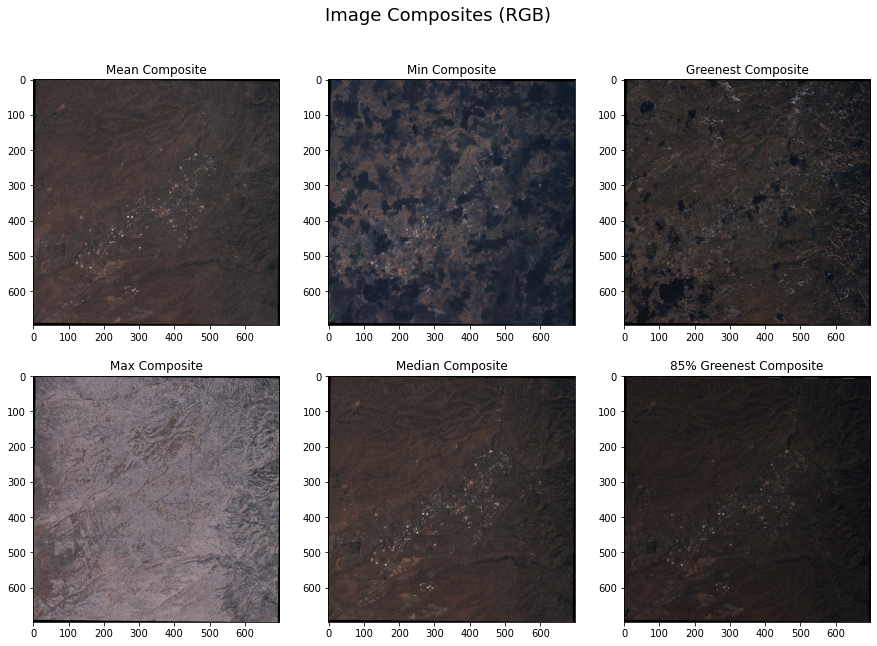

In [ ]:
f, axarr = plt.subplots(2,3, figsize = (15,10))

axarr[0,0].imshow(bands_to_rgb(bands = composites['mean']))
axarr[0,0].set_title('Mean Composite')
axarr[0,1].imshow(bands_to_rgb(bands = composites['min']))
axarr[0,1].set_title('Min Composite')

axarr[1,0].imshow(bands_to_rgb(bands = composites['max']))
axarr[1,0].set_title('Max Composite')
axarr[1,1].imshow(bands_to_rgb(bands = composites['median']))
axarr[1,1].set_title('Median Composite')

axarr[0,2].imshow(bands_to_rgb(bands = composites['greenest']))
axarr[0,2].set_title('Greenest Composite')
axarr[1,2].imshow(bands_to_rgb(bands = composites['85p_greenest']))
axarr[1,2].set_title('85% Greenest Composite')

f.suptitle('Image Composites (RGB)', fontsize = 18)
plt.show()

##### Composite Comments

The composites look good to me. The median, mean, and 85% greenest resemble each other a lot, which makes sense as they are the 'less extreme' aggregation metrics. 

The max image is all snowy, which is reasonable because snow is white which has a high pixel value. The min composite has a bunch of splotches of dark, which I believe are due to the cloud shadows. This makes sense, as my masking didn't remove these shadows and because darker pixels have lower RGB values. The greenest composite seems to containe a lot of residual clouds and some of their shadows. In some of the previous parts of the assignment I saw that clouds can very much influence the NDVI value, so it makes sense that these would appear in the final composite (sadly though, as it means my algorithm still could use some tweeks). 


#### Saving as .geotiff

In [ ]:
FORMAT = "GTiff"

#Create a composite folder if it doesn't already exist
if not os.path.exists(WORK_DIR+'Composites'):
  os.mkdir(WORK_DIR+'Composites')
  print('composite folder creates')
else:
  print('composite folder already exists')

composite folder creates


In [ ]:
# We already have a raster loaded from before as ds (when we imported then bands)
ds = gdal.Open(mod_paths[0])

# Setting up the driver
driver = gdal.GetDriverByName(FORMAT)
driver.Register()

2

In [ ]:
# Create the tifs
for comp in composites.keys():
  # Grab the path
  path = WORK_DIR+'Composites/'+comp+'_comp.tif'

  # Creating a tif file with parameters from gdal.warp output
  outds = driver.Create(path,
                        xsize = in_band.XSize,
                        ysize = in_band.YSize,
                        bands = len(composites['mean'].keys()),
                        eType = gdal.GDT_Float32)

  outds.SetProjection(ds.GetProjection())
  outds.SetGeoTransform(ds.GetGeoTransform())

  ## Looping through the bands and saving them into the output geotiff
  for band_i, band_name in enumerate(composites['mean'].keys()):
    # Get the band
    band_i = band_i+1 #start 
    band = outds.GetRasterBand(band_i)

    # set band description
    in_band = ds.GetRasterBand(band_i)
    band.SetDescription(in_band.GetDescription())

    # write out
    band.WriteArray(composites[comp][band_name])
    band.SetNoDataValue(np.nan)
    band.FlushCache()

    # Clear output band
    band = None
  # Clear dataset
  outds = None

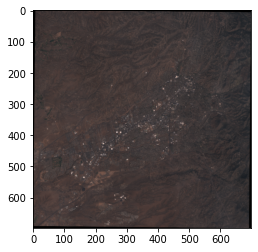

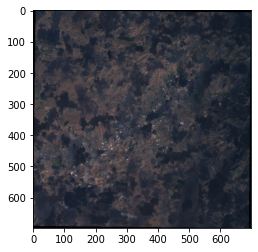

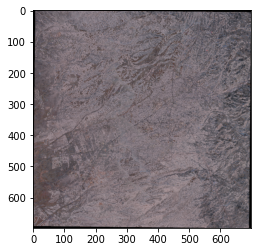

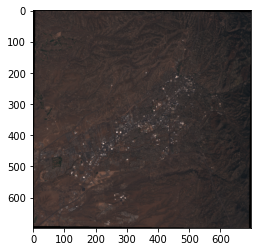

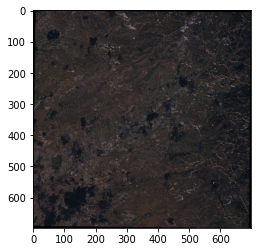

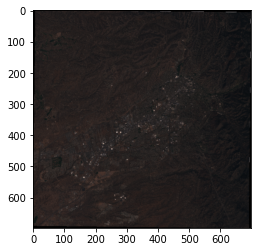

In [ ]:
# Importing and checking that the composites were saved properly
for comp in composites.keys():
  path = WORK_DIR+'Composites/'+comp+'_comp.tif'
  ds = gdal.Open(path)

  r = ds.GetRasterBand(1).ReadAsArray()
  g = ds.GetRasterBand(2).ReadAsArray()
  b = ds.GetRasterBand(3).ReadAsArray()

  im = np.dstack((r,g,b))
  im = im/im.max()
  plt.imshow(im)
  plt.show()

##### Saving Comments

I only looked at the RBG values of the saved images, but they look exactly the same as those I intended to save. This means that I most likely saved correctly (as the loop performs the same actions for all bands).